In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import joblib

In [2]:
EPOCHS = 200
BATCH_SIZE = 32

In [3]:
data = np.load("../data/processed_data.npz")
X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]
dir_test = data["dir_test"]
window_size = int(data["window_size"])

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((308, 10), (308,), (80, 10), (80,))

In [5]:
y_train.min(), y_train.max(), y_train.mean(), y_train.std()

(0.0, 1.0, 0.5694548173904032, 0.2436574353149964)

In [6]:
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

In [7]:
model = Sequential()

model.add(LSTM(128, input_shape=(window_size, 1), return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.1))

model.add(Dense(16, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=5e-4, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                5

In [8]:
es = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('../models/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    callbacks=[es, rlrp, checkpoint],
    verbose=1
)

Epoch 1/200
6/9 [===================>..........] - ETA: 0s - loss: 0.2114 
Epoch 1: val_loss improved from inf to 0.14895, saving model to ../models\best_model.keras
9/9 [==============================] - 6s 109ms/step - loss: 0.1913 - val_loss: 0.1489 - lr: 5.0000e-04
Epoch 2/200
6/9 [===================>..........] - ETA: 0s - loss: 0.0265
Epoch 2: val_loss improved from 0.14895 to 0.02054, saving model to ../models\best_model.keras
9/9 [==============================] - 0s 19ms/step - loss: 0.0279 - val_loss: 0.0205 - lr: 5.0000e-04
Epoch 3/200
5/9 [===============>..............] - ETA: 0s - loss: 0.0195
Epoch 3: val_loss did not improve from 0.02054
9/9 [==============================] - 0s 15ms/step - loss: 0.0164 - val_loss: 0.0481 - lr: 5.0000e-04
Epoch 4/200
6/9 [===================>..........] - ETA: 0s - loss: 0.0171
Epoch 4: val_loss improved from 0.02054 to 0.01507, saving model to ../models\best_model.keras
9/9 [==============================] - 0s 25ms/step - loss: 0.015

In [10]:
train_loss = history.history['loss'][-1]
val_loss = history.history.get('val_loss', [None])[-1]
print(f"Final losses -> train: {train_loss:.6f}, val: {val_loss:.6f}")

Final losses -> train: 0.006289, val: 0.006135


In [11]:
scaler_X = joblib.load('../models/scaler_X.pkl')
scaler_y = joblib.load('../models/scaler_y.pkl')

In [12]:
pred_scaled = model.predict(X_test).flatten()
predicted = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

3/3 [==============================] - 1s 6ms/step


In [13]:
prev_scaled = X_test.reshape(X_test.shape[0], window_size)[:, -1].reshape(-1, 1)
prev_actuals = scaler_X.inverse_transform(prev_scaled).flatten()

In [16]:
predictions_on_true_test = predicted[window_size:]
actuals_on_true_test = y_test[window_size:]
prev_actuals_true_test = prev_actuals[window_size:]

In [17]:
pred_dir_binary = (predictions_on_true_test > prev_actuals_true_test).astype(int)
actual_dir_binary = (actuals_on_true_test > prev_actuals_true_test).astype(int)

In [ ]:
direction_accuracy = (pred_dir_binary == actual_dir_binary).mean() * 100
print(f"Direction accuracy (predicted > previous actual): {direction_accuracy:.2f}%")

Direction accuracy (predicted > previous actual): 41.43%


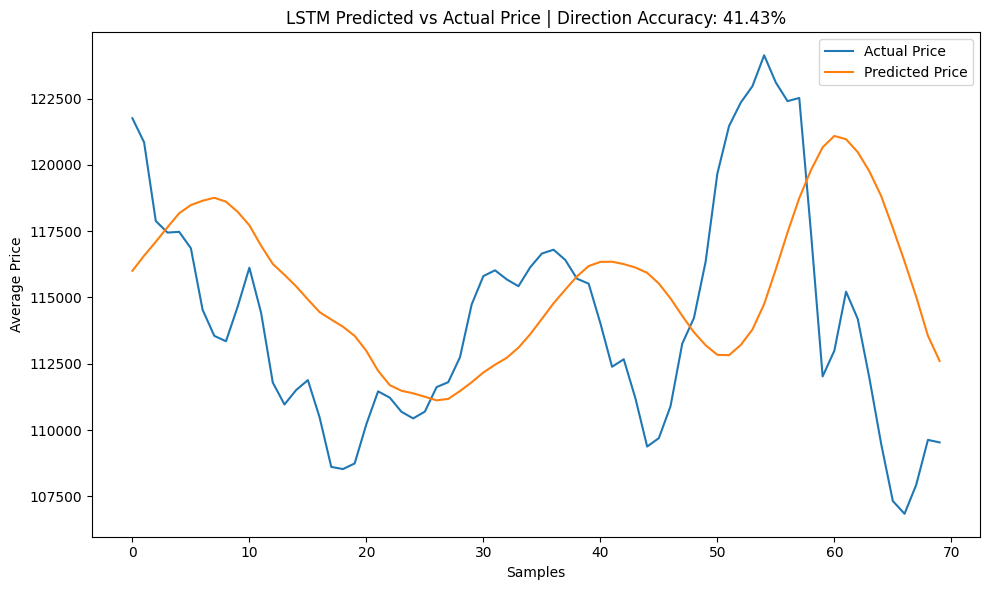

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(actuals_on_true_test, label="Actual Price")
plt.plot(predictions_on_true_test, label="Predicted Price")
plt.title(f"LSTM Predicted vs Actual Price | Direction Accuracy: {direction_accuracy:.2f}%")
plt.xlabel("Samples")
plt.ylabel("Average Price")
plt.legend()
plt.tight_layout()
plt.show()